# Week 4: Integrating Census Data and Isochrones for BRT Route Analysis
For this week, I plan to bring together several techniques we've learned so far to pair with our project topic. Aziz will be looking at BRT routes in Los Angeles, and I'm checking out several proposed routes in Atlanta. Because MARTA does not yet operate any BRT in Atlanta, I took the three routes proposed in the More MARTA program and mapped them with geojson.io. Of the three lines, only the Capitol Ave line has reached the stage of planning where stop/station locations have been proposed. For the other two lines, I made rough guesses for stop siting, based on the number of stops versus route length for Capitol Ave, which gave me a stop roughly each .3 miles. 

My goal for this notebook is to import the geoJSON file I created, make sure it is accurate, and create isochrone walksheds for the 41 stops. I'm hoping to write a function to automate the process!

## Importing and Checking my geoJSON file

In [2]:
import geopandas as gpd

import matplotlib.pyplot as plt

import networkx as nx

import osmnx as ox

import contextily as ctx

In [3]:
ATL = gpd.read_file('data/MARTA_BRT_routes_stops.geojson')

In [4]:
ATL.shape

(44, 6)

The dataset has several default columns from the geojson.io webiste that I didn't edit. For today, I'll ignore them, though at some point I may go back and make some changes so that it looks prettier.

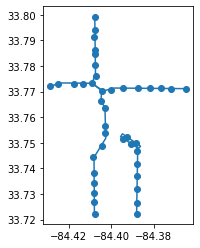

In [6]:
#plotting the dataset to make sure it looks alright!
ATL.plot()

I did realize one modification I need to make - I created this file with points for stop locations as well as lines sketching the routes, but I only want to create isochrones from the stop locations.

In [7]:
ATL.head(44)

,marker-color,marker-size,marker-symbol,Stop,Route,geometry
0,#7e7e7e,medium,,Ridge Ave/Hank Aaron Dr,Capitol Ave BRT,POINT (-84.38813 33.72222)
1,#7e7e7e,medium,,Haygood Ave/Hank Aaron Dr,Capitol Ave BRT,POINT (-84.38803 33.72657)
2,#7e7e7e,medium,,Ormond St/Hank Aaron Ave,Capitol Ave BRT,POINT (-84.38796 33.73179)
3,#7e7e7e,medium,,Georgia Ave/Capitol Ave,Capitol Ave BRT,POINT (-84.38787 33.73687)
4,#7e7e7e,medium,,Fulton St/Capitol Ave,Capitol Ave BRT,POINT (-84.38780 33.74189)
5,#7e7e7e,medium,,Memorial Dr/Capitol Ave,Capitol Ave BRT,POINT (-84.38772 33.74693)
6,#7e7e7e,medium,,Washington St/MLK Dr,Capitol Ave BRT,POINT (-84.38845 33.75008)
7,#7e7e7e,medium,,Broad St/MLK Dr,Capitol Ave BRT,POINT (-84.39279 33.75244)
8,#7e7e7e,medium,,Forsyth St/Mitchell St,Capitol Ave BRT,POINT (-84.39433 33.75165)
9,#7e7e7e,medium,,Central Ave/Mitchell St,Capitol Ave BRT,POINT (-84.39065 33.74966)


In [5]:
#drop rows with 'None' values (note:I think I had to do it this way because the None values were strings, rather than NaN floats)
ATL = ATL.mask(ATL.eq('None')).dropna()

In [9]:
ATL.head(20)

,marker-color,marker-size,marker-symbol,Stop,Route,geometry
0,#7e7e7e,medium,,Ridge Ave/Hank Aaron Dr,Capitol Ave BRT,POINT (-84.38813 33.72222)
1,#7e7e7e,medium,,Haygood Ave/Hank Aaron Dr,Capitol Ave BRT,POINT (-84.38803 33.72657)
2,#7e7e7e,medium,,Ormond St/Hank Aaron Ave,Capitol Ave BRT,POINT (-84.38796 33.73179)
3,#7e7e7e,medium,,Georgia Ave/Capitol Ave,Capitol Ave BRT,POINT (-84.38787 33.73687)
4,#7e7e7e,medium,,Fulton St/Capitol Ave,Capitol Ave BRT,POINT (-84.38780 33.74189)
5,#7e7e7e,medium,,Memorial Dr/Capitol Ave,Capitol Ave BRT,POINT (-84.38772 33.74693)
6,#7e7e7e,medium,,Washington St/MLK Dr,Capitol Ave BRT,POINT (-84.38845 33.75008)
7,#7e7e7e,medium,,Broad St/MLK Dr,Capitol Ave BRT,POINT (-84.39279 33.75244)
8,#7e7e7e,medium,,Forsyth St/Mitchell St,Capitol Ave BRT,POINT (-84.39433 33.75165)
9,#7e7e7e,medium,,Central Ave/Mitchell St,Capitol Ave BRT,POINT (-84.39065 33.74966)


## Generating an isochrone for one stop
Now that the dataframe is ready to go, I'm going to practice creating an isochrone based on a single stop location, before trying to create a function for all stops.

In [12]:
#set the base variables
place = ATL.iloc[0, 5]
print(place)

POINT (-84.38813209533691 33.72221587346768)


I've extracted a coordinate field, but then realized I need to convert so it can be accepted in OSMnx.

In [6]:
#create new columns with the stripped coordinates from 'geometry'
ATL['lon'] = ATL['geometry'].x
ATL['lat'] = ATL['geometry'].y
place = ATL.iloc[0,7], ATL.iloc[0,6]
print(place)

In [32]:
network_type = 'walk'
trip_times = [5,10,15]
meters_per_minute = 75

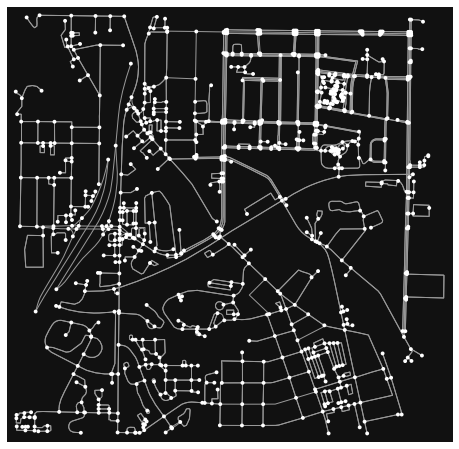

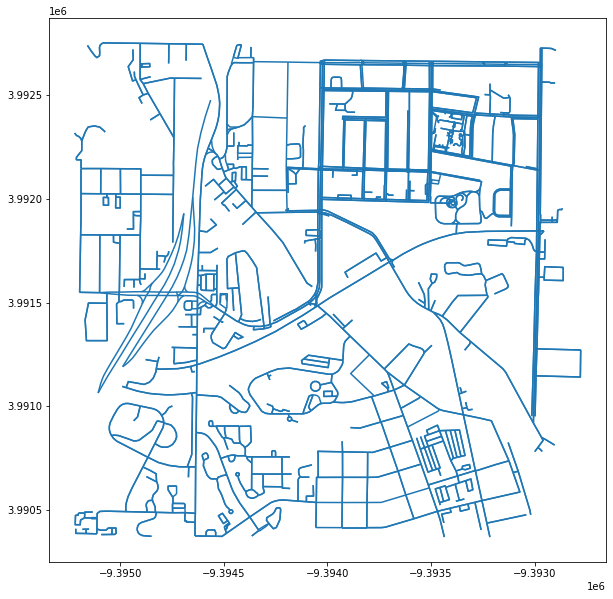

In [24]:
#bring in the OSM data
G = ox.graph.graph_from_point(place, dist=1000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
# quick plot using oxmnx
fig, ax = ox.plot_graph(G)                    

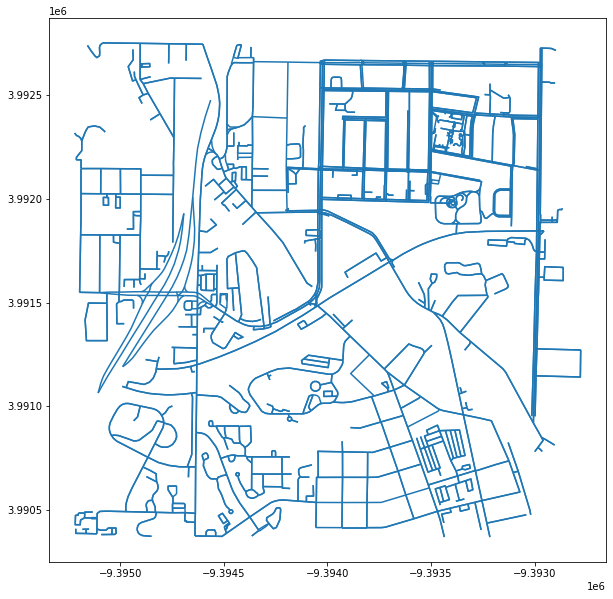

In [25]:
#convert to Web Mercator
G = ox.project_graph(G, to_crs='epsg:3857')
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.plot(figsize=(10,10)) 

In [26]:
# get bounding box, calculate centroid, and get nearest node
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')

-9395219.639697313
3990368.6767837796
-9392862.104389345
3992753.0263490616
-9394040.87204333
3991560.851566421


In [33]:
#set up isochrone
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap='viridis', 
                                start=0, 
                                return_hex=True)

trip_times.sort(reverse=True)
time_color = list(zip(trip_times, iso_colors))
time_color

for time,color in list(time_color):
    print('The color for '+str(time)+' minutes is ' + color)

The color for 15 minutes is #440154
The color for 10 minutes is #21918c
The color for 5 minutes is #fde725


In [34]:
#color nodes based on travel time group
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ')
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color

There are 565 nodes within 15 minutes 
There are 208 nodes within 10 minutes 
There are 45 nodes within 5 minutes 


In [36]:
#checking progress
gdf_nodes['color'].fillna('#cccccc', inplace=True)
gdf_nodes[['osmid','highway','time','color']].sample(20)

,osmid,highway,time,color
5426092900,5426092900,NaN,15 mins,#440154
8250436752,8250436752,NaN,NaN,#cccccc
6960403378,6960403378,NaN,NaN,#cccccc
5424161716,5424161716,NaN,NaN,#cccccc
7022209083,7022209083,crossing,15 mins,#440154
6960403309,6960403309,crossing,15 mins,#440154
3722874206,3722874206,NaN,10 mins,#21918c
69163288,69163288,NaN,15 mins,#440154
5424164022,5424164022,NaN,NaN,#cccccc
315306497,315306497,NaN,15 mins,#440154


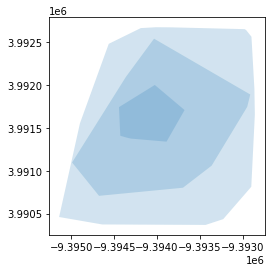

In [39]:
#create polygons for each time area
isochrones = gdf_nodes.dissolve('time')
isochrones = isochrones.convex_hull.reset_index()
isochrones.columns=['time','geometry']
isochrones.plot(alpha=.2)

## Let's Make a Map
Now that I've created the isochrones, I need to set up the basemap and project the isochrones on it.

In [46]:
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=10)


<Figure size 432x288 with 0 Axes>

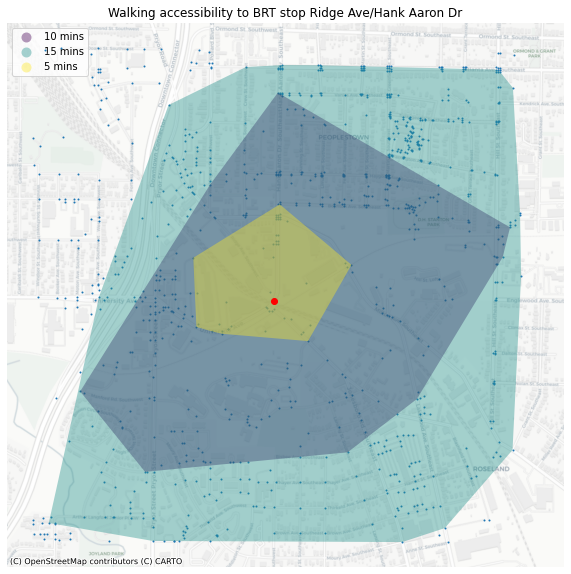

In [51]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               alpha = .2,
               edgecolor='gainsboro', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=1, 
               zorder=10)

# add the center node in red
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)
# add isochrones
isochrones.plot(alpha=.4,
               ax=ax,
               column='time',
               cmap='viridis',
               legend=True,
               zorder=20)

# no axis
ax.axis('off')

# title
ax.set_title('Walking accessibility to BRT stop ' + ATL.iloc[0,3])

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Ok, so the first isochrone mapping test worked! On to making this an easy plug and play process.

## Writing a function to generate isochrone
I know just enough Python to be dangerous (or in this case, to give me an idea of how to build a function). I'll map out the sections of code I need to write to make it work, then fill in as I go. I expect there may be memory issues, so if I run into that problem, I'll split the dataset into smaller batches to work through.

In [9]:
#just trying to figure out the iterrows function here with some practice
for index, row in ATL.iterrows():
    print('This stop is named: ' + row['Stop'])

This stop is named: Ridge Ave/Hank Aaron Dr
This stop is named: Haygood Ave/Hank Aaron Dr
This stop is named: Ormond St/Hank Aaron Ave
This stop is named: Georgia Ave/Capitol Ave
This stop is named: Fulton St/Capitol Ave
This stop is named: Memorial Dr/Capitol Ave
This stop is named: Washington St/MLK Dr
This stop is named: Broad St/MLK Dr
This stop is named: Forsyth St/Mitchell St
This stop is named: Central Ave/Mitchell St
This stop is named: Angier Ave/North Ave
This stop is named: Holmes St/Northside Dr
This stop is named: University Ave/Metropolitan Pkwy
This stop is named: Stiff St/North Ave
This stop is named: Trabert Ave/Northside Dr
This stop is named: 17th St/Northside Dr
This stop is named: 14th St/Northside Dr
This stop is named: Ethel St/Northside Dr
This stop is named: Marietta St/Northside St
This stop is named: North Ave/Northside Dr (W)
This stop is named: North Ave/Northside Dr (E)
This stop is named: Maple St/Northside Dr
This stop is named: MLK Dr/Northside Dr
This 

In [ ]:
#set variables at the top so they can be easily changed as needed
network_type = 'walk'
trip_times = [5,10,15]
meters_per_minute = 75
###I think the place variable needs to be inside the for loop(?)
#define the function
def isomap(gdf):
    G = ox.graph.graph_from_point(place, dist=1000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    G = ox.project_graph(G, to_crs='epsg:3857')
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

    iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                    cmap='viridis', 
                                    start=0, 
                                    return_hex=True)

    trip_times.sort(reverse=True)
    time_color = list(zip(trip_times, iso_colors))
    time_color
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #gdf_edges.plot(figsize=(10,10))
    
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')  
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time) + ' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns=['time','geometry']
    #isochrones.plot(alpha=.2)
    
    
    
    fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
    gdf_edges.plot(ax=ax,
                   linewidth=0.5,
                   alpha = .2,
                   edgecolor='gainsboro', 
                   zorder=10)

# add all nodes to ax
    gdf_nodes.plot(ax=ax, 
                   markersize=1, 
                   zorder=10)

# add the center node in red
    gdf_nodes.loc[[center_node]].plot(ax=ax,
                                      color='r', 
                                      zorder=30)
# add isochrones
    isochrones.plot(alpha=.4,
                   ax=ax,
                   column='time',
                   cmap='viridis',
                   legend=True,
                   zorder=20)

# no axis
    ax.axis('off')

# title
    ax.set_title('Walking accessibility to BRT stop ' + row['Stop']) ###this also needs to iterate w/the process

# add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [ ]:
#run the function for all values in the list
for index,row in test.iterrows():
    place = row[7], row[6] #gotta make sure this cycles through
    isomap(test)
#win!

I tested this function in a separate notebook, "Isochrone Function Test," also uploaded to my Github, to keep it separate and try to avoid memory overload.

## Revisions
Honestly, I'm shocked that I got this work. One of the libraries contained within (I think matplotlib, need to try it again and look at the error more closely) won't allow more than 20 images to be produced, and I'll run into memory issues at that scale too. But the function did iterate through a subset I defined - all rows with a 'Capitol Ave BRT' value in the 'Route' column! 
A few to-dos:
- Remove nodes from the final map
- Output a single map with every station's isochrones, rather than individual maps for each coordinate
- Clean up function and make clear instructions for importing, formatting, and iterating over a dataset